In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.api import GLS, add_constant
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import warnings
# Suppress FutureWarnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

np.random.seed(123)

def update(P, PET, corr, noise):
    
    # generate artificial data
    sd_P, sd_PET = 0.1*P, 0.1*PET  
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([P, PET])
    sample = stats.multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=['P', 'PET'])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2) 
    
    P_range, PET_range = df_art['P'], df_art['PET']
    sens_P_values, sens_PET_values = zip(*[calculate_sensitivities(P, PET, 2) for P, PET in zip(P_range, PET_range)])
    sens_P_mean, sens_PET_mean = round(np.mean(sens_P_values), 2), round(np.mean(sens_PET_values), 2)
    
    df_art["P"] = df_art["P"] * (1 - np.random.uniform(0, noise, len(df_art))) # - noise*df_art["P"]
    df_art["PET"] = df_art["PET"] * (1 + np.random.normal(0, noise, len(df_art)))
    df_art["Q"] = df_art["Q"] * (1 + np.random.normal(0, noise, len(df_art)))
    
    # estimate sensitivities with different methods
    X_noncentered, y_noncentered = df_art[["P", "PET"]], df_art["Q"]
    sens_P_method1, sens_PET_method1 = map(round, LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_, [2, 2])
    
    X_centered, y_centered = df_art[["P", "PET"]] - df_art[["P", "PET"]].mean(), df_art["Q"] - df_art["Q"].mean()
    sens_P_method2, sens_PET_method2 = map(round, LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_, [2, 2])
    
    #ridge_model = Ridge(alpha=1, fit_intercept=False).fit(X_noncentered, y_noncentered)
    #sens_P_method3, sens_PET_method3 = map(round, ridge_model.coef_, [2, 2])
    sens_P_method3 = np.median((df_art["Q"] - df_art["Q"].mean())/(df_art["P"] - df_art["P"].mean())) 
    sens_PET_method3 = np.median((df_art["Q"] - df_art["Q"].mean())/(df_art["PET"] - df_art["PET"].mean())) 
    
    model_P_Q, model_PET_Q = LinearRegression().fit(df_art[['P']], df_art['Q']), LinearRegression().fit(df_art[['PET']], df_art['Q'])
    sens_P_method4 = round(model_P_Q.coef_[0], 2)
    sens_PET_method4 = round(model_PET_Q.coef_[0], 2)
    
    log_X = np.log(df_art[["P", "PET"]])
    log_y = np.log(df_art["Q"])
    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
    sens_P_method5 = round(log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean(), 2)
    sens_PET_method5 = round(log_model.coef_[1] * df_art["Q"].mean() / df_art["PET"].mean(), 2)
    
    X_gls = add_constant(df_art[["P", "PET"]])
    gls_model = GLS(df_art["Q"], X_gls).fit()
    sens_P_method6 = round(gls_model.params[1], 2)
    sens_PET_method6 = round(gls_model.params[2], 2)

    residual_Q_after_PET, residual_Q_after_P = df_art['Q'] - model_PET_Q.predict(df_art[['PET']]), df_art['Q'] - model_P_Q.predict(df_art[['P']])
    
    # visualise results
    fig, axs = plt.subplots(2, 3, figsize=(8, 5))
    
    methods_and_stats = ['Theoretical', 'Multiple Reg.', 'Delta Reg.', 'Nonparam.', 'Single Reg.', 'Log Reg.', 'GLS']
    sensitivities_combined = [sens_P_mean, sens_PET_mean, sens_P_method1, sens_PET_method1, sens_P_method2, sens_PET_method2, sens_P_method3, sens_PET_method3, sens_P_method4, sens_PET_method4, sens_P_method5, sens_PET_method5, sens_P_method6, sens_PET_method6]
    bar_positions_combined = np.arange(len(sensitivities_combined))
    bar_colors = ['darkgrey', 'darkgrey', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:orange', 'tab:orange', 'tab:purple', 'tab:purple', 'tab:green', 'tab:green', 'tab:brown', 'tab:brown']
    axs[0, 0].bar(bar_positions_combined, sensitivities_combined, color=bar_colors)
    bar_positions_labels = np.arange(0.5,round(len(sensitivities_combined)),2)
    axs[0, 0].set_xticks(bar_positions_labels)
    axs[0, 0].set_xticklabels(methods_and_stats, rotation=80)
    axs[0, 0].set_ylabel("PET sensitivity [-] /  P sensitivity [-]")
    axs[0, 0].axhline(sens_P_mean, color='darkgrey', linestyle='--', linewidth=2)
    axs[0, 0].axhline(sens_PET_mean, color='darkgrey', linestyle=':', linewidth=2)
    axs[0, 0].set_ylim(-1.25, 1.23)
    
    axs[0, 1].scatter(df_art['P'], df_art['Q'], color='tab:blue', alpha=0.6)
    axs[0, 1].set_xlabel('P [mm/yr]'), axs[0, 1].set_ylabel('Q [mm/yr]'), 
    
    axs[0, 2].scatter(df_art['PET'], df_art['Q'], color='tab:orange')
    axs[0, 2].set_xlabel('PET [mm/yr]'), axs[0, 2].set_ylabel('Q [mm/yr]', alpha=0.6), 
    
    axs[1, 0].scatter(df_art['P'], df_art['PET'], color='darkgrey')
    axs[1, 0].set_xlabel('P [mm/yr]'), axs[1, 0].set_ylabel('PET [mm/yr]', alpha=0.6), 
    
    axs[1, 1].scatter(df_art['P'], residual_Q_after_PET, color='tab:blue', alpha=0.6)
    axs[1, 1].set_xlabel('P [mm/yr]'), axs[1, 1].set_ylabel('Q | PET removed [mm/yr]'), 
    
    axs[1, 2].scatter(df_art['PET'], residual_Q_after_P, color='tab:orange', alpha=0.6)
    axs[1, 2].set_xlabel('PET [mm/yr]'), axs[1, 2].set_ylabel('Q | P removed [mm/yr]'), 
    
    #axs[1, 1].scatter(df_art['P']-df_art['P'].mean(), df_art['Q']-df_art['Q'].mean(), color='tab:blue')
    #axs[1, 1].set_xlabel('dP [mm/yr]'), axs[1, 1].set_ylabel('dQ [mm/yr]'), 
    
    #axs[1, 2].scatter(df_art['PET']-df_art['PET'].mean(), df_art['Q']-df_art['Q'].mean(), color='tab:orange')
    #axs[1, 2].set_xlabel('dPET [mm/yr]'), axs[1, 2].set_ylabel('dQ [mm/yr]'), 
    
    plt.tight_layout()
    plt.show()

P_slider, PET_slider = widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='P'), widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='PET')
corr_slider, noise_slider = widgets.FloatSlider(value=0.0, min=-1, max=1, step=0.01, description='Correlation'), widgets.FloatSlider(value=0.0, min=0, max=0.20, step=0.01, description='Noise')

interactive_plot = interactive(update, P=P_slider, PET=PET_slider, corr=corr_slider, noise=noise_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot


# todo: stepwise regression as in Zhang et al.
# todo: weighted regression...
# todo: test estimating the whole thing by averaging over 5 or more years.


interactive(children=(FloatSlider(value=800.0, description='P', max=2000.0, min=200.0, step=10.0), FloatSlider…

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.api import GLS, add_constant
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_elasticities(P, PET, n):
    Q = calculate_streamflow(P, PET, n)
    dQ_dP = 1 - (1 + (P/PET)**n)**((-1/n)-1)
    dQ_dPET = -(1 + (PET/P)**n)**((-1/n)-1)
    # Convert to elasticities (dQ/Q)/(dX/X) = (dQ/dX)*(X/Q)
    elasticity_P = dQ_dP * (P/Q)
    elasticity_PET = dQ_dPET * (PET/Q)
    return elasticity_P, elasticity_PET

np.random.seed(123)

def update(P, PET, corr, noise):
    # Generate artificial data
    sd_P, sd_PET = 0.1*P, 0.1*PET  
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([P, PET])
    sample = stats.multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=['P', 'PET'])
    df_art["Q"] = calculate_streamflow(df_art["P"], df_art["PET"], 2)
    
    # Calculate theoretical elasticities
    P_range, PET_range = df_art['P'], df_art['PET']
    elast_P_vals, elast_PET_vals = zip(*[calculate_elasticities(p, pet, 2) 
                                       for p, pet in zip(P_range, PET_range)])
    elast_P_mean, elast_PET_mean = round(np.mean(elast_P_vals),2), round(np.mean(elast_PET_vals),2)
    
    # Add noise
    df_art["P"] *= (1 - np.random.uniform(0, noise, len(df_art)))
    df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    # Elasticity estimation methods
    X, y = df_art[["P", "PET"]], df_art["Q"]
    Q_mean, P_mean, PET_mean = y.mean(), X['P'].mean(), X['PET'].mean()
    
    # Method 1: Multiple regression
    m1 = LinearRegression(fit_intercept=False).fit(X, y)
    elast_P1 = round(m1.coef_[0] * P_mean/Q_mean, 2)
    elast_PET1 = round(m1.coef_[1] * PET_mean/Q_mean, 2)
    
    # Method 2: Centered data
    X_centered = X - X.mean()
    y_centered = y - y.mean()
    m2 = LinearRegression(fit_intercept=False).fit(X_centered, y_centered)
    elast_P2 = round(m2.coef_[0] * P_mean/Q_mean, 2)
    elast_PET2 = round(m2.coef_[1] * PET_mean/Q_mean, 2)
    
    # Method 3: Nonparametric
    elast_P3 = round(np.median((y - y.mean())/(X['P'] - P_mean) * P_mean/Q_mean), 2)
    elast_PET3 = round(np.median((y - y.mean())/(X['PET'] - PET_mean) * PET_mean/Q_mean), 2)
    
    # Method 4: Single regressions
    m4_P = LinearRegression().fit(X[['P']], y)
    m4_PET = LinearRegression().fit(X[['PET']], y)
    elast_P4 = round(m4_P.coef_[0] * P_mean/Q_mean, 2)
    elast_PET4 = round(m4_PET.coef_[0] * PET_mean/Q_mean, 2)
    
    # Method 5: Log-log regression (direct elasticity)
    log_model = LinearRegression().fit(np.log(X), np.log(y))
    elast_P5 = round(log_model.coef_[0], 2)
    elast_PET5 = round(log_model.coef_[1], 2)
    
    # Method 6: GLS
    gls_model = GLS(y, add_constant(X)).fit()
    elast_P6 = round(gls_model.params[1] * P_mean/Q_mean, 2)
    elast_PET6 = round(gls_model.params[2] * PET_mean/Q_mean, 2)

    # Visualization
    fig, axs = plt.subplots(2, 3, figsize=(8, 5))
    methods = ['Theoretical', 'Mult.Reg.', 'Centered', 'Nonparam.', 'Single Reg.', 'Log Reg.', 'GLS']
    elasticities = [elast_P_mean, elast_PET_mean,
                   elast_P1, elast_PET1,
                   elast_P2, elast_PET2,
                   elast_P3, elast_PET3,
                   elast_P4, elast_PET4,
                   elast_P5, elast_PET5,
                   elast_P6, elast_PET6]
    
    colors = ['darkgrey']*2 + ['tab:blue']*2 + ['tab:red']*2 + ['tab:orange']*2 + ['tab:purple']*2 + ['tab:green']*2 + ['tab:brown']*2
    axs[0,0].bar(range(len(elasticities)), elasticities, color=colors)
    axs[0,0].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,0].set_xticklabels(methods, rotation=80)
    axs[0,0].axhline(elast_P_mean, color='darkgrey', linestyle='--')
    axs[0,0].axhline(elast_PET_mean, color='darkgrey', linestyle=':')
    axs[0,0].set_ylabel("Elasticity [-]")
    axs[0,0].set_ylim(-2, 3)
    
    # Scatter plots remain similar
    axs[0,1].scatter(df_art['P'], df_art['Q'], alpha=0.6, color='tab:blue')
    axs[0,1].set(xlabel='P [mm/yr]', ylabel='Q [mm/yr]')
    axs[0,2].scatter(df_art['PET'], df_art['Q'], alpha=0.6, color='tab:orange')
    axs[0,2].set(xlabel='PET [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[1,0].scatter(df_art['P'], df_art['PET'], alpha=0.6, color='grey')
    axs[1,0].set(xlabel='P [mm/yr]', ylabel='PET [mm/yr]')
    
    # Residual plots
    res_P = y - m4_PET.predict(X[['PET']])
    res_PET = y - m4_P.predict(X[['P']])
    axs[1,1].scatter(X['P'], res_P, alpha=0.6, color='tab:blue')
    axs[1,1].set(xlabel='P [mm/yr]', ylabel='Q | PET removed [mm/yr]')
    axs[1,2].scatter(X['PET'], res_PET, alpha=0.6, color='tab:orange')
    axs[1,2].set(xlabel='PET [mm/yr]', ylabel='Q | P removed [mm/yr]')
    
    plt.tight_layout()
    plt.show()

# Slider setup remains the same
P_slider, PET_slider = widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='P'), widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='PET')
corr_slider, noise_slider = widgets.FloatSlider(value=0.0, min=-1, max=1, step=0.01, description='Correlation'), widgets.FloatSlider(value=0.0, min=0, max=0.20, step=0.01, description='Noise')

interactive_plot = interactive(update, P=P_slider, PET=PET_slider, 
                              corr=corr_slider, noise=noise_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot


interactive(children=(FloatSlider(value=800.0, description='P', max=2000.0, min=200.0, step=10.0), FloatSlider…

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.api import GLS, add_constant
import statsmodels.api as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_elasticities(P, PET, n):
    Q = calculate_streamflow(P, PET, n)
    dQ_dP = 1 - (1 + (P/PET)**n)**((-1/n)-1)
    dQ_dPET = -(1 + (PET/P)**n)**((-1/n)-1)
    # Convert to elasticities (dQ/Q)/(dX/X) = (dQ/dX)*(X/Q)
    elasticity_P = dQ_dP * (P/Q)
    elasticity_PET = dQ_dPET * (PET/Q)
    return elasticity_P, elasticity_PET

np.random.seed(123)

def update(P, PET, corr, noise):
    # Generate artificial data
    sd_P, sd_PET = 0.1*P, 0.1*PET  
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([P, PET])
    sample = stats.multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=['P', 'PET'])
    df_art["Q"] = calculate_streamflow(df_art["P"], df_art["PET"], 2)
    
    # Calculate theoretical elasticities
    P_range, PET_range = df_art['P'], df_art['PET']
    elast_P_vals, elast_PET_vals = zip(*[calculate_elasticities(p, pet, 2) 
                                       for p, pet in zip(P_range, PET_range)])
    elast_P_mean, elast_PET_mean = round(np.mean(elast_P_vals),2), round(np.mean(elast_PET_vals),2)
    
    # Add noise
    df_art["P"] *= (1 - np.random.uniform(0, noise, len(df_art)))
    df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    # Elasticity estimation methods
    X, y = df_art[["P", "PET"]], df_art["Q"]
    Q_mean, P_mean, PET_mean = y.mean(), X['P'].mean(), X['PET'].mean()
    X_centered = X.copy()
    X_centered['P'] = X['P'] - P_mean
    X_centered['PET'] = X['PET'] - PET_mean
    y_centered = y - Q_mean
    
    # Method 1: Multiple regression
    m1 = LinearRegression(fit_intercept=False).fit(X, y)
    elast_P1 = round(m1.coef_[0] * P_mean/Q_mean, 2)
    elast_PET1 = round(m1.coef_[1] * PET_mean/Q_mean, 2)
    
    # Method 2: Centered data
    m2 = LinearRegression(fit_intercept=False).fit(X_centered, y_centered)
    elast_P2 = round(m2.coef_[0] * P_mean/Q_mean, 9)
    elast_PET2 = round(m2.coef_[1] * PET_mean/Q_mean, 9)

    # Method 3: Nonparametric
    elast_P3 = round(np.median((y - y.mean())/(X['P'] - P_mean) * P_mean/Q_mean), 2)
    elast_PET3 = round(np.median((y - y.mean())/(X['PET'] - PET_mean) * PET_mean/Q_mean), 2)
    
    # Method 4: Single regressions
    m4_P = LinearRegression().fit(X[['P']], y)
    m4_PET = LinearRegression().fit(X[['PET']], y)
    elast_P4 = round(m4_P.coef_[0] * P_mean/Q_mean, 2)
    elast_PET4 = round(m4_PET.coef_[0] * PET_mean/Q_mean, 2)
    
    # Method 5: Log-log regression (direct elasticity)
    log_model = LinearRegression().fit(np.log(X), np.log(y))
    elast_P5 = round(log_model.coef_[0], 2)
    elast_PET5 = round(log_model.coef_[1], 2)
    
    # Method 6: GLS
    #n = len(X['P'])
    #correlation = np.corrcoef(X['P'], X['PET'])[0, 1]
    #variance_P, variance_PET = np.var(X['P']), np.var(X['PET'])
    #cov_matrix = correlation * np.sqrt(variance_P * variance_PET) * np.ones((n, n))
    #np.fill_diagonal(cov_matrix, variance_P + variance_PET)  
    #gls_model = GLS(y, add_constant(X), sigma=cov_matrix).fit()
    gls_model = GLS(y, add_constant(X)).fit()
    elast_P6 = round(gls_model.params[1] * P_mean/Q_mean, 2)
    elast_PET6 = round(gls_model.params[2] * PET_mean/Q_mean, 2)

    # Method 7: WLS
    initial_model = LinearRegression(fit_intercept=True).fit(X, y)
    y_pred = initial_model.predict(X)
    residuals = np.abs(y - y_pred)
    weights = 1 / (residuals + 1e-6)
    X_with_constant = sm.add_constant(X, has_constant='add') 
    wls_model = sm.WLS(y, X_with_constant, weights=weights).fit()
    coef = wls_model.params[1:] 
    elast_P7 = round(coef[0] * P_mean / Q_mean, 2)
    elast_PET7 = round(coef[1] * PET_mean / Q_mean, 2)
    
    # Method 8: averaging
    n_years = 10
    data = pd.DataFrame({"Q": y, "P": X['P'], "PET": X['PET']})
    #data["year"] = np.arange(len(data)) // n_years
    #averaged_data = data.groupby("year").mean()
    data["Q"] = data["Q"].rolling(window=n_years, center=True).mean()
    data["P"] = data["P"].rolling(window=n_years, center=True).mean()
    data["PET"] = data["PET"].rolling(window=n_years, center=True).mean()
    averaged_data = data.dropna()
    y_avg = averaged_data["Q"].values
    X_avg = averaged_data[["P", "PET"]].values
    m8 = LinearRegression(fit_intercept=True).fit(X_avg, y_avg)
    elast_P8 = round(m8.coef_[0] * P_mean / Q_mean, 2)
    elast_PET8 = round(m8.coef_[1] * PET_mean / Q_mean, 2)

    # Visualization
    fig, axs = plt.subplots(2, 3, figsize=(8, 5))
    methods = ['Theoretical', 'Mult.Reg.', 'Centered', 'Nonparam.', 'Single Reg.', 'Log Reg.', 'GLS', 'WLS', 'Averaging']
    elasticities = [elast_P_mean, elast_PET_mean,
                   elast_P1, elast_PET1,
                   elast_P2, elast_PET2,
                   elast_P3, elast_PET3,
                   elast_P4, elast_PET4,
                   elast_P5, elast_PET5,
                   elast_P6, elast_PET6,
                   elast_P7, elast_PET7,
                   elast_P8, elast_PET8]
    
    colors = ['darkgrey']*2 + ['tab:blue']*2 + ['tab:red']*2 + ['tab:orange']*2 + ['tab:purple']*2 + ['tab:green']*2 + ['tab:brown']*2 + ['tab:olive']*2 + ['tab:cyan']*2 
    axs[0,0].bar(range(len(elasticities)), elasticities, color=colors)
    axs[0,0].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,0].set_xticklabels(methods, rotation=80)
    axs[0,0].axhline(elast_P_mean, color='darkgrey', linestyle='--')
    axs[0,0].axhline(elast_PET_mean, color='darkgrey', linestyle=':')
    axs[0,0].set_ylabel("Elasticity [-]")
    axs[0,0].set_ylim(-2, 3)


    epsilon = 1e-10
    elasticity_error = [
        (elast_P_mean - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET_mean - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P1 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET1 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P2 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET2 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P3 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET3 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P4 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET4 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P5 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET5 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P6 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET6 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P7 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET7 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon),
        (elast_P8 - elast_P_mean) / (abs(elast_P_mean) + epsilon),
        (elast_PET8 - elast_PET_mean) / (abs(elast_PET_mean) + epsilon)
    ]
    axs[0,1].bar(range(len(elasticity_error)), elasticity_error, color=colors)
    axs[0,1].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,1].set_xticklabels(methods, rotation=80)
    axs[0,1].axhline(0, color='darkgrey', linestyle='--')
    axs[0,1].set_ylabel("Rel. error [-]")
    axs[0,1].set_ylim(-0.5, 0.5)

    # Scatter plots remain similar
    axs[1,0].scatter(df_art['P'], df_art['Q'], alpha=0.6, color='tab:blue')
    axs[1,0].scatter(averaged_data['P'], averaged_data['Q'], alpha=0.6, color='tab:purple')
    axs[1,0].set(xlabel='P [mm/yr]', ylabel='Q [mm/yr]')
    axs[1,1].scatter(df_art['PET'], df_art['Q'], alpha=0.6, color='tab:orange')
    axs[1,1].scatter(averaged_data['PET'], averaged_data['Q'], alpha=0.6, color='tab:red')
    axs[1,1].set(xlabel='PET [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[0,2].scatter(df_art['P'], df_art['PET'], alpha=0.6, color='grey')
    axs[0,2].scatter(averaged_data['P'], averaged_data['PET'], alpha=0.6, color='black')
    axs[0,2].set(xlabel='P [mm/yr]', ylabel='PET [mm/yr]')
    
    # Residual plots
    res_P = y - m4_PET.predict(X[['PET']])
    res_PET = y - m4_P.predict(X[['P']])
    axs[1,2].scatter(X['P'], res_P, alpha=0.6, color='tab:blue')
    axs[1,2].scatter(X['PET'], res_PET, alpha=0.6, color='tab:orange')
    axs[1,2].set(xlabel='P or PET [mm/yr]', ylabel='Q | P or PET rem. [mm/yr]')

    plt.tight_layout()
    plt.show()

# Slider setup remains the same
P_slider, PET_slider = widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='P'), widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='PET')
corr_slider, noise_slider = widgets.FloatSlider(value=0.0, min=-1, max=1, step=0.01, description='Correlation'), widgets.FloatSlider(value=0.0, min=0, max=0.20, step=0.01, description='Noise')

interactive_plot = interactive(update, P=P_slider, PET=PET_slider, 
                              corr=corr_slider, noise=noise_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot
# It is okay to use an estimated regression model to predict y or estimate as long as you do so within the model's scope.
# We can no longer make much sense of the usual interpretation of a slope coefficient as the change in the mean response for each additional unit increases in the predictor when all the other predictors are held constant. 
# The first point is, of course, addressed above. The second point is a direct consequence of the correlation among the predictors. 
# It wouldn't make sense to talk about holding the values of correlated predictors constant since changing one predictor necessarily would change the values of the others.
# https://compgenomr.github.io/book/dealing-with-correlated-predictors.html

interactive(children=(FloatSlider(value=800.0, description='P', max=2000.0, min=200.0, step=10.0), FloatSlider…

In [11]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from statsmodels.api import GLS, WLS, add_constant
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import warnings

# Suppress FutureWarnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to calculate streamflow based on P, PET, and n
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

# Function to calculate sensitivities dQ/dP and dQ/dPET
def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

np.random.seed(123)

# Update function for interactive plotting
def update(P, PET, corr, noise):
    
    # Generate artificial data with specified correlation and noise
    sd_P, sd_PET = 0.1 * P, 0.1 * PET  
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([P, PET])
    sample = stats.multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=['P', 'PET'])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2) 
    
    # Calculate theoretical sensitivities for each data point
    P_range, PET_range = df_art['P'], df_art['PET']
    sens_P_values, sens_PET_values = zip(*[calculate_sensitivities(P, PET, 2) for P, PET in zip(P_range, PET_range)])
    sens_P_mean, sens_PET_mean = round(np.mean(sens_P_values), 2), round(np.mean(sens_PET_values), 2)
    
    # Add noise to the data
    df_art["P"] *= (1 - np.random.uniform(0, noise, len(df_art)))
    df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    # Estimate sensitivities using different methods
    
    # Method 1: Multiple regression (non-centered data)
    X_noncentered = df_art[["P", "PET"]]
    y_noncentered = df_art["Q"]
    sens_P_method1, sens_PET_method1 = map(round, LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_, [2, 2])
    
    # Method 2: Multiple regression (centered data)
    X_centered = df_art[["P", "PET"]] - df_art[["P", "PET"]].mean()
    y_centered = df_art["Q"] - df_art["Q"].mean()
    sens_P_method2, sens_PET_method2 = map(round, LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_,  [2, 2])
    
    # Method 3: Nonparametric estimation (median of ratios)
    sens_P_method3 = round(np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["P"] - df_art["P"].mean())), 2)
    sens_PET_method3 = round(np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["PET"] - df_art["PET"].mean())), 2)
    
    # Method 4: Single regressions (independent variables separately)
    model_P_Q = LinearRegression().fit(df_art[['P']], df_art['Q'])
    model_PET_Q = LinearRegression().fit(df_art[['PET']], df_art['Q'])
    sens_P_method4 = round(model_P_Q.coef_[0], 2)
    sens_PET_method4 = round(model_PET_Q.coef_[0], 2)
    
    # Method 5: Log-log regression (converted elasticities to sensitivities)
    log_X = np.log(df_art[["P", "PET"]])
    log_y = np.log(df_art["Q"])
    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
    sens_P_method5 = round(log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean(), 2)
    sens_PET_method5 = round(log_model.coef_[1] * df_art["Q"].mean() / df_art["PET"].mean(), 2)
    
    # Method 6: Generalized Least Squares (GLS)
    X_gls = add_constant(df_art[["P", "PET"]])
    gls_model = GLS(df_art["Q"], X_gls).fit()
    sens_P_method6 = round(gls_model.params[1], 2)
    sens_PET_method6 = round(gls_model.params[2], 2)

    # Method 7: Weighted Least Squares (WLS)
    initial_model = LinearRegression(fit_intercept=True).fit(X_noncentered, y_noncentered)
    residuals = np.abs(y_noncentered - initial_model.predict(X_noncentered))
    weights = 1 / (residuals + 1e-6)
    wls_model = WLS(y_noncentered, add_constant(X_noncentered), weights=weights).fit()
    sens_P_method7 = round(wls_model.params[1], 2)
    sens_PET_method7 = round(wls_model.params[2], 2)

    # Method 8: Multi-year averaging
    n_years = 10
    data_avg = pd.DataFrame({"Q": y_noncentered, "P": X_noncentered['P'], "PET": X_noncentered['PET']})
    data_avg["Q"] = data_avg["Q"].rolling(window=n_years, center=True).mean()
    data_avg["P"] = data_avg["P"].rolling(window=n_years, center=True).mean()
    data_avg["PET"] = data_avg["PET"].rolling(window=n_years, center=True).mean()
    averaged_data = data_avg.dropna()
    m8_avg_model = LinearRegression(fit_intercept=True).fit(averaged_data[["P", "PET"]], averaged_data["Q"])
    sens_P_method8 = round(m8_avg_model.coef_[0], 2)
    sens_PET_method8 = round(m8_avg_model.coef_[1], 2)

    # Visualization
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    
    methods = ['Theoretical', 'Mult.Reg.', 'Centered', 'Nonparam.', 'Single Reg.', 'Log Reg.', 'GLS', 'WLS', 'Averaging']
    sensitivities = [sens_P_mean, sens_PET_mean,
                     sens_P_method1, sens_PET_method1,
                     sens_P_method2, sens_PET_method2,
                     sens_P_method3, sens_PET_method3,
                     sens_P_method4, sens_PET_method4,
                     sens_P_method5, sens_PET_method5,
                     sens_P_method6, sens_PET_method6,
                     sens_P_method7, sens_PET_method7,
                     sens_P_method8, sens_PET_method8]
    
    colors = ['darkgrey']*2 + ['tab:blue']*2 + ['tab:red']*2 + ['tab:orange']*2 + ['tab:purple']*2 + ['tab:green']*2 + ['tab:brown']*2 + ['tab:olive']*2 + ['tab:cyan']*2 
    axs[0,0].bar(range(len(sensitivities)), sensitivities, color=colors)
    axs[0,0].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,0].set_xticklabels(methods, rotation=80)
    axs[0,0].axhline(sens_P_mean, color='darkgrey', linestyle='--')
    axs[0,0].axhline(sens_PET_mean, color='darkgrey', linestyle=':')
    axs[0,0].set_ylabel("Sensitivity [-]")
    axs[0,0].set_ylim(-1.25, 1.25)

    epsilon = 1e-10
    sensitivity_error = [
        (sens_P_mean - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_mean - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method1 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method1 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method2 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method2 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method3 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method3 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method4 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method4 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method5 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method5 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method6 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method6 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method7 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method7 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        (sens_P_method8 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        (sens_PET_method8 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon)
    ]
    
    axs[0,1].bar(range(len(sensitivity_error)), sensitivity_error, color=colors)
    axs[0,1].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,1].set_xticklabels(methods, rotation=80)
    axs[0,1].axhline(0, color='darkgrey', linestyle='--')
    axs[0,1].set_ylabel("Rel. error [-]")
    axs[0,1].set_ylim(-0.5, 0.5)

    # Scatter plots remain similar
    axs[1,0].scatter(df_art['P'], df_art['Q'], alpha=0.6, color='tab:blue')
    axs[1,0].scatter(averaged_data['P'], averaged_data['Q'], alpha=0.6, color='tab:purple')
    axs[1,0].set(xlabel='P [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[1,1].scatter(df_art['PET'], df_art['Q'], alpha=0.6, color='tab:orange')
    axs[1,1].scatter(averaged_data['PET'], averaged_data['Q'], alpha=0.6, color='tab:red')
    axs[1,1].set(xlabel='PET [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[0,2].scatter(df_art['P'], df_art['PET'], alpha=0.6, color='grey')
    axs[0,2].scatter(averaged_data['P'], averaged_data['PET'], alpha=0.6, color='black')
    axs[0,2].set(xlabel='P [mm/yr]', ylabel='PET [mm/yr]')
    
    # Residual plots
    res_P = y_noncentered - model_PET_Q.predict(X_noncentered[['PET']])
    res_PET = y_noncentered - model_P_Q.predict(X_noncentered[['P']])
    axs[1,2].scatter(X_noncentered['P'], res_P, alpha=0.6, color='tab:blue', label='Residuals after PET removed')
    axs[1,2].scatter(X_noncentered['PET'], res_PET, alpha=0.6, color='tab:orange', label='Residuals after P removed')
    axs[1,2].set(xlabel='P or PET [mm/yr]', ylabel='Residual Q [mm/yr]')

    # Finalize and display the plot
    plt.tight_layout()
    plt.show()

# Slider setup remains the same
P_slider, PET_slider = widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='P'), widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='PET')
corr_slider, noise_slider = widgets.FloatSlider(value=0.0, min=-1, max=1, step=0.01, description='Correlation'), widgets.FloatSlider(value=0.0, min=0, max=0.20, step=0.01, description='Noise')

interactive_plot = interactive(update, P=P_slider, PET=PET_slider, 
                              corr=corr_slider, noise=noise_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

# choose:
# Comparison: Nonparam., Single Reg.
# For actual analysis: Mult. Reg., Centered, Log Reg., Averaging 
# Omit: Intercept because it's the same as centered, GLS and WLS because the results are the same (or worse), same for Ridge and Lasso... 
# (they basically fit the same problem... and it's not the fit but rather what is fitted)


interactive(children=(FloatSlider(value=800.0, description='P', max=2000.0, min=200.0, step=10.0), FloatSlider…

In [19]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from statsmodels.api import GLS, WLS, add_constant
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import warnings

# Suppress FutureWarnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to calculate streamflow based on P, PET, and n
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

# Function to calculate sensitivities dQ/dP and dQ/dPET
def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

np.random.seed(123)


# choose:
# Comparison: Nonparam., Single Reg.
# For actual analysis: Mult. Reg., Centered, Log Reg., Averaging 
# Omit: Intercept because it's the same as centered, GLS and WLS because the results are the same (or worse), same for Ridge and Lasso... 
# (they basically fit the same problem... and it's not the fit but rather what is fitted)


# Update function for interactive plotting
def update(P, PET, corr, noise):
    
    # Generate artificial data with specified correlation and noise
    sd_P, sd_PET = 0.1 * P, 0.1 * PET  
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([P, PET])
    sample = stats.multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=['P', 'PET'])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2) 
    
    # Calculate theoretical sensitivities for each data point
    P_range, PET_range = df_art['P'], df_art['PET']
    sens_P_values, sens_PET_values = zip(*[calculate_sensitivities(P, PET, 2) for P, PET in zip(P_range, PET_range)])
    sens_P_mean, sens_PET_mean = round(np.mean(sens_P_values), 2), round(np.mean(sens_PET_values), 2)
    
    # Add noise to the data
    df_art["P"] *= (1 - np.random.uniform(0, noise, len(df_art)))
    df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    # Estimate sensitivities using different methods
        
    # Method 1: Nonparametric estimation (median of ratios)
    sens_P_method1 = round(np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["P"] - df_art["P"].mean())), 2)
    sens_PET_method1 = round(np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["PET"] - df_art["PET"].mean())), 2)
    
    # Method 2: Single regressions (independent variables separately)
    model_P_Q = LinearRegression().fit(df_art[['P']], df_art['Q'])
    model_PET_Q = LinearRegression().fit(df_art[['PET']], df_art['Q'])
    sens_P_method2 = round(model_P_Q.coef_[0], 2)
    sens_PET_method2 = round(model_PET_Q.coef_[0], 2)
    
    # Method 3: Multiple regression (non-centered data)
    X_noncentered = df_art[["P", "PET"]]
    y_noncentered = df_art["Q"]
    sens_P_method3, sens_PET_method3 = map(round, LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_, [2, 2])
    
    # Method 4: Multiple regression (centered data)
    X_centered = df_art[["P", "PET"]] - df_art[["P", "PET"]].mean()
    y_centered = df_art["Q"] - df_art["Q"].mean()
    sens_P_method4, sens_PET_method4 = map(round, LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_,  [2, 2])

    # Method 5: Log-log regression (converted elasticities to sensitivities)
    log_X = np.log(df_art[["P", "PET"]])
    log_y = np.log(df_art["Q"])
    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
    sens_P_method5 = round(log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean(), 2)
    sens_PET_method5 = round(log_model.coef_[1] * df_art["Q"].mean() / df_art["PET"].mean(), 2)

    # Method 6: Multi-year averaging
    n_years = 10
    data_avg = pd.DataFrame({"Q": y_noncentered, "P": X_noncentered['P'], "PET": X_noncentered['PET']})
    data_avg["Q"] = data_avg["Q"].rolling(window=n_years, center=True).mean()
    data_avg["P"] = data_avg["P"].rolling(window=n_years, center=True).mean()
    data_avg["PET"] = data_avg["PET"].rolling(window=n_years, center=True).mean()
    averaged_data = data_avg.dropna()
    m8_avg_model = LinearRegression(fit_intercept=True).fit(averaged_data[["P", "PET"]], averaged_data["Q"])
    sens_P_method6 = round(m8_avg_model.coef_[0], 2)
    sens_PET_method6 = round(m8_avg_model.coef_[1], 2)

    # Visualization
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    
    methods = ['Theoretical', 'Nonparam.', 'Single Reg.', 'Mult. Reg. #1', 'Mult. Reg. #2', 'Mult. Reg. Log', 'Averaging']
    sensitivities = [sens_P_mean, sens_PET_mean,
                     sens_P_method1, sens_PET_method1,
                     sens_P_method2, sens_PET_method2,
                     sens_P_method3, sens_PET_method3,
                     sens_P_method4, sens_PET_method4,
                     sens_P_method5, sens_PET_method5,
                     sens_P_method6, sens_PET_method6]
    
    colors = ['darkgrey']*2 + ['tab:blue']*2 + ['tab:red']*2 + ['tab:orange']*2 + ['tab:purple']*2 + ['tab:green']*2 + ['tab:brown']*2
    axs[0,0].bar(range(len(sensitivities)), sensitivities, color=colors)
    axs[0,0].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,0].set_xticklabels(methods, rotation=80)
    axs[0,0].axhline(sens_P_mean, color='darkgrey', linestyle='--')
    axs[0,0].axhline(sens_PET_mean, color='darkgrey', linestyle=':')
    axs[0,0].set_ylabel("Sensitivity [-]")
    axs[0,0].set_ylim(-1.25, 1.25)

    epsilon = 1e-10
    sensitivity_error = [
        100*(sens_P_mean - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_mean - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method1 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method1 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method2 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method2 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method3 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method3 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method4 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method4 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method5 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method5 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method6 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method6 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon)
    ]
    
    axs[0,1].bar(range(len(sensitivity_error)), sensitivity_error, color=colors)
    axs[0,1].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,1].set_xticklabels(methods, rotation=80)
    axs[0,1].axhline(0, color='darkgrey', linestyle='--')
    axs[0,1].set_ylabel("Rel. error [%]")
    axs[0,1].set_ylim(-25, 25)

    # Scatter plots remain similar
    axs[1,0].scatter(df_art['P'], df_art['Q'], alpha=0.6, color='tab:blue')
    axs[1,0].scatter(averaged_data['P'], averaged_data['Q'], alpha=0.6, color='tab:purple')
    axs[1,0].set(xlabel='P [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[1,1].scatter(df_art['PET'], df_art['Q'], alpha=0.6, color='tab:orange')
    axs[1,1].scatter(averaged_data['PET'], averaged_data['Q'], alpha=0.6, color='tab:red')
    axs[1,1].set(xlabel='PET [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[0,2].scatter(df_art['P'], df_art['PET'], alpha=0.6, color='grey')
    axs[0,2].scatter(averaged_data['P'], averaged_data['PET'], alpha=0.6, color='black')
    axs[0,2].set(xlabel='P [mm/yr]', ylabel='PET [mm/yr]')
    
    # Residual plots
    res_P = y_noncentered - model_PET_Q.predict(X_noncentered[['PET']])
    res_PET = y_noncentered - model_P_Q.predict(X_noncentered[['P']])
    axs[1,2].scatter(X_noncentered['P'], res_P, alpha=0.6, color='tab:blue', label='Residuals after PET removed')
    axs[1,2].scatter(X_noncentered['PET'], res_PET, alpha=0.6, color='tab:orange', label='Residuals after P removed')
    axs[1,2].set(xlabel='P or PET [mm/yr]', ylabel='Residual Q [mm/yr]')

    # Finalize and display the plot
    plt.tight_layout()
    plt.show()

# Slider setup remains the same
P_slider, PET_slider = widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='P'), widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='PET')
corr_slider, noise_slider = widgets.FloatSlider(value=0.0, min=-1, max=1, step=0.01, description='Correlation'), widgets.FloatSlider(value=0.0, min=0, max=0.20, step=0.01, description='Noise')

interactive_plot = interactive(update, P=P_slider, PET=PET_slider, 
                              corr=corr_slider, noise=noise_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot


interactive(children=(FloatSlider(value=800.0, description='P', max=2000.0, min=200.0, step=10.0), FloatSlider…

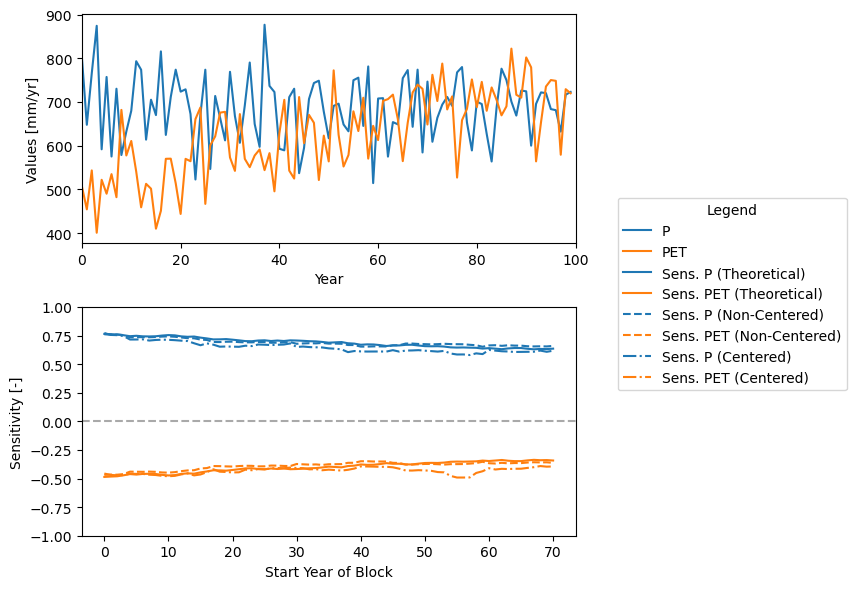

In [43]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define functions to calculate streamflow and sensitivities
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

# Generate correlated random series with trends
np.random.seed(123)
years = np.arange(100)  # 100 years

# Set correlation and noise level
corr = -0.5  # Correlation between P and PET
noise_level = 0.01  # Noise level

# Generate correlated P and PET time series
mean_P, mean_PET = 700, 500
sd_P, sd_PET = 75, 50
cov_P_PET = corr * sd_P * sd_PET  # Covariance between P and PET
sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])  # Covariance matrix
mu = np.array([mean_P, mean_PET])  # Mean values for P and PET

# Generate correlated samples for P and PET with trends
trend_P = 0.0
trend_PET = 0.5
samples = multivariate_normal(mu, sigma).rvs(len(years))
P = samples[:, 0] * (1 +  trend_P * years / max(years))
PET = samples[:, 1] * (1 +  trend_PET * years / max(years))  # Add trend to PET
Q = calculate_streamflow(P, PET, n=2)

# Add noise to the series
Q += np.random.normal(0, noise_level * mean_P, len(years))
P += np.random.normal(0, noise_level * mean_P, len(years))
PET += np.random.normal(0, noise_level * mean_PET, len(years))

# Create DataFrame
df = pd.DataFrame({'Year': years, 'P': P, 'PET': PET, 'Q': Q})

# Calculate sensitivities for 30-year moving blocks
block_size = 30
sens_P_theoretical = []
sens_PET_theoretical = []
sens_P_noncentered = []
sens_PET_noncentered = []
sens_P_centered = []
sens_PET_centered = []

for start in range(len(years) - block_size + 1):
    block = df.iloc[start:start + block_size]
    
    # Theoretical sensitivities based on mean P and PET in the block
    mean_P_block = block['P'].mean()
    mean_PET_block = block['PET'].mean()
    sens_P, sens_PET = calculate_sensitivities(mean_P_block, mean_PET_block, n=2)
    sens_P_theoretical.append(sens_P)
    sens_PET_theoretical.append(sens_PET)
    
    # Method: Non-centered multiple regression
    X_noncentered = block[["P", "PET"]]
    y_noncentered = block["Q"]
    model_noncentered = LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered)
    sens_P_nc, sens_PET_nc = model_noncentered.coef_
    sens_P_noncentered.append(sens_P_nc)
    sens_PET_noncentered.append(sens_PET_nc)
    
    # Method: Centered multiple regression
    X_centered = X_noncentered - X_noncentered.mean()
    y_centered = y_noncentered - y_noncentered.mean()
    model_centered = LinearRegression(fit_intercept=False).fit(X_centered, y_centered)
    sens_P_c, sens_PET_c = model_centered.coef_
    sens_P_centered.append(sens_P_c)
    sens_PET_centered.append(sens_PET_c)

# Create DataFrame for sensitivities
df_sens = pd.DataFrame({
    'Start_Year': years[:len(sens_P_theoretical)],
    'Sens_P_Theoretical': sens_P_theoretical,
    'Sens_PET_Theoretical': sens_PET_theoretical,
    'Sens_P_NonCentered': sens_P_noncentered,
    'Sens_PET_NonCentered': sens_PET_noncentered,
    'Sens_P_Centered': sens_P_centered,
    'Sens_PET_Centered': sens_PET_centered
})

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

# Plot P and PET trends
axs[0].plot(df['Year'], df['P'], label='P', color='tab:blue')
axs[0].plot(df['Year'], df['PET'], label='PET', color='tab:orange')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Values [mm/yr]')
axs[0].set_xlim(0, 100)

# Plot sensitivities (theoretical vs non-centered and centered methods)
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_P_Theoretical'], label='Sens. P (Theoretical)', color='tab:blue', linestyle='-')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_PET_Theoretical'], label='Sens. PET (Theoretical)', color='tab:orange', linestyle='-')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_P_NonCentered'], label='Sens. P (Non-Centered)', color='tab:blue', linestyle='--')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_PET_NonCentered'], label='Sens. PET (Non-Centered)', color='tab:orange', linestyle='--')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_P_Centered'], label='Sens. P (Centered)', color='tab:blue', linestyle='-.')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_PET_Centered'], label='Sens. PET (Centered)', color='tab:orange', linestyle='-.')
axs[1].axhline(0, color='darkgrey', linestyle='--')
axs[1].set_xlabel('Start Year of Block')
axs[1].set_ylabel('Sensitivity [-]')
axs[1].set_ylim(-1, 1)

# Move legend outside the plots
handles_0, labels_0 = axs[0].get_legend_handles_labels()
handles_1, labels_1 = axs[1].get_legend_handles_labels()

fig.legend(handles_0 + handles_1, labels_0 + labels_1,
           loc="center right", bbox_to_anchor=(0.85, 0.5), title="Legend")

plt.tight_layout(rect=[0, 0, 0.6, 1])  # Adjust layout to make space for the legend
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

# Define functions to calculate streamflow and sensitivities
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

# Generate synthetic data based on correlation and noise
def generate_data(p_mean, pet_mean, corr, noise):
    sd_P = 0.1 * p_mean
    sd_PET = 0.1 * pet_mean
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([p_mean, pet_mean])
    sample = multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=["P", "PET"])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2)

    # Add noise if specified
    if noise > 0:
        df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["P"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    # Calculate streamflow
    
    return df_art

# Main plotting function
def plot_sensitivities():
    # Define parameter ranges and settings
    p_means = np.linspace(200, 2000, 50)  # P values
    pet_means = np.linspace(200, 2000, 50)  # PET values
    correlations = [-0.5, 0.0, 0.5]  # Correlation values
    noise_levels = [0.0, 0.025]  # 95% will lie within two standard deviations (±2*X%) of the mean.

    
    fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
    
    for j, noise in enumerate(noise_levels):  # Columns: Noise levels
        for i, corr in enumerate(correlations):  # Rows: Different correlations
            results = []
            
            for p_mean in p_means:
                for pet_mean in pet_means:
                    # Generate data
                    df_art = generate_data(p_mean=p_mean, pet_mean=pet_mean, corr=corr, noise=noise)
                    
                    # Calculate theoretical sensitivities
                    sens_P_theory, sens_PET_theory = calculate_sensitivities(p_mean, pet_mean, n=2)
                    
                    # Calculate aridity index (PET/P)
                    aridity_index = pet_mean / p_mean
                    
                    # Method 1: Nonparametric estimation (median of ratios)
                    sens_P_method1 = np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["P"] - df_art["P"].mean()))
                    sens_PET_method1 = np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["PET"] - df_art["PET"].mean()))
                    
                    # Method 2: Single regressions (independent variables separately)
                    model_P_Q = LinearRegression().fit(df_art[['P']], df_art['Q'])
                    model_PET_Q = LinearRegression().fit(df_art[['PET']], df_art['Q'])
                    sens_P_method2 = model_P_Q.coef_[0]
                    sens_PET_method2 = model_PET_Q.coef_[0]
                    
                    # Method 3: Multiple regression (non-centered data)
                    X_noncentered = df_art[["P", "PET"]]
                    y_noncentered = df_art["Q"]
                    sens_P_method3, sens_PET_method3 = LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_
                    
                    # Method 4: Multiple regression (centered data)
                    X_centered = X_noncentered - X_noncentered.mean()
                    y_centered = y_noncentered - y_noncentered.mean()
                    sens_P_method4, sens_PET_method4 = LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_
                    
                    # Method 5: Log-log regression (elasticities converted to sensitivities)
                    log_X = np.log(df_art[["P", "PET"]])
                    log_y = np.log(df_art["Q"])
                    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
                    sens_P_method5 = log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean()
                    sens_PET_method5 = log_model.coef_[1] * df_art["Q"].mean() / df_art["PET"].mean()

                    # Append results for all methods and theoretical values
                    results.extend([
                        {"aridity_index": aridity_index,
                         "method": "Theoretical", "sens_P": sens_P_theory,
                         "sens_PET": sens_PET_theory},
                        {"aridity_index": aridity_index,
                         "method": "Nonparametric", "sens_P": sens_P_method1,
                         "sens_PET": sens_PET_method1},
                        {"aridity_index": aridity_index,
                         "method": "Single Reg.", "sens_P": sens_P_method2,
                         "sens_PET": sens_PET_method2},
                        {"aridity_index": aridity_index,
                         "method": "Mult. Reg. #1",
                         "sens_P": sens_P_method3,
                         "sens_PET": sens_PET_method3},
                        {"aridity_index": aridity_index,
                         "method": "Mult. Reg. #2",
                         "sens_P": sens_P_method4,
                         "sens_PET": sens_PET_method4},
                        {"aridity_index": aridity_index,
                         "method": "Mult. Reg. log",
                         "sens_P": sens_P_method5,
                         "sens_PET": sens_PET_method5}
                        ])
                        
            # Define custom colors for each method
            custom_palette = {
                'Theoretical': 'black',
                'Nonparametric': 'lightgrey',
                'Single Reg.': 'grey',
                'Mult. Reg. #1': 'tab:orange',
                'Mult. Reg. #2': 'tab:red',
                'Mult. Reg. log': 'tab:purple',
                'Averaging': 'tab:blue'
            }
            
            # Convert results to DataFrame for plotting
            results_df = pd.DataFrame(results)
            results_melted = results_df.melt(
                id_vars=["aridity_index", "method"],
                value_vars=["sens_P", "sens_PET"],
                var_name="variable",
                value_name="sensitivity"
            )
            
            # Bin the aridity index
            results_melted['aridity_bin'] = pd.cut(results_melted['aridity_index'], bins=25)

            # Calculate the median and percentiles for each bin and method
            binned_stats = results_melted.groupby(['aridity_bin', 'method', 'variable'])['sensitivity'].agg(
                median='median',
                q25=lambda x: np.percentile(x, 5),
                q75=lambda x: np.percentile(x, 95)
            ).reset_index()
            
            # Plot sensitivities vs aridity index for each method and variable
            ax = axs[i][j]

            # Iterate through each method and variable to plot
            for method in results_melted['method'].unique():
                for variable in results_melted['variable'].unique():
                    subset = binned_stats[(binned_stats['method'] == method) & (binned_stats['variable'] == variable)]
                    
                    # Get the x-axis values (midpoint of each aridity bin)
                    x_vals = subset['aridity_bin'].apply(lambda x: x.mid)
                    
                    # Plot the median line
                    ax.plot(x_vals, subset['median'], label=f'{method} {variable}', color=custom_palette[method], alpha=0.5)
                    
                    # Plot the shaded area for the 25th to 75th percentile range
                    ax.fill_between(x_vals, subset['q25'], subset['q75'], alpha=0.1, color=custom_palette[method])

            ax.legend().remove()
            ax.set_title(f"Corr={corr}, Noise={noise}")
            ax.set_xlabel("Aridity index [-]")
            ax.set_ylabel("Sensitivity [-]")
            ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
            ax.set_xscale("log")
            ax.set_xlim(0.1, 10)
            ax.set_ylim(-1.5, 1.5)

    # Create a single legend outside all subplots
    handles, labels = axs[0][0].get_legend_handles_labels()  # Get handles and labels from one of the subplots
    #fig.legend(handles, labels, loc="center right", title="Methods", bbox_to_anchor=(1.15, 0.5))
    
    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.tight_layout()
    plt.show()

# Call the plotting function to display the figure
plot_sensitivities()
